<a href="https://colab.research.google.com/github/markoo26/thehappymountain/blob/main/Statsmodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title 🪅 Install libraries

!pip install pmdarima
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 13.0 MB/s eta 0:00:00


In [37]:
#@title 🚚 Imports

# Core
import numpy as np
import pandas as pd

# Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import jarque_bera, durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from scipy.signal import periodogram

# Sklearn
from sklearn.linear_model import RidgeCV, LassoCV

# Scipy
from scipy import stats
from scipy.stats import ttest_1samp, ttest_ind, f_oneway

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Finance & Time Series
import yfinance as yf
import pmdarima as pm
from arch import arch_model

# 📖 Datasets

In [4]:
#@title 🚓 Prepare `mtcars` dataset

mtcars_data = sm.datasets.get_rdataset("mtcars", "datasets").data
display(mtcars_data.head())

px.histogram(pd.Series(mtcars_data['mpg'], name='Miles per gallon'), title='Histogram of miles per gallon')

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
rownames,,,,,,,,,,,
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [5]:
#@title 🚢 Prepare ships dataset

ships_data = sm.datasets.get_rdataset("ships", "MASS").data
ships_data = ships_data[ships_data['incidents'] > 0]  # remove zero service rows

display(ships_data.head())

px.histogram(pd.Series(ships_data['incidents'], name='Incidents'), title='Histogram of incidents in ships data')

,type,year,period,service,incidents
2,A,65,60,1095,3
3,A,65,75,1095,4
4,A,70,60,1512,6
5,A,70,75,3353,18
7,A,75,75,2244,11


In [6]:
#@title 💸 Prepare insurance dataset
#@markdown Dropping 0 claims to properly fit Gamma distribution, which requires values to be **strictly** positive

insurance_data = sm.datasets.get_rdataset("Insurance", "MASS").data

insurance_data = insurance_data[insurance_data['Claims'] > 0]

display(insurance_data.head())

px.histogram(pd.Series(insurance_data['Claims'], name='Incidents'), title='Histogram of insurance claims data')


,District,Group,Age,Holders,Claims
0,1,<1l,<25,197,38
1,1,<1l,25-29,264,35
2,1,<1l,30-35,246,20
3,1,<1l,>35,1680,156
4,1,1-1.5l,<25,284,63


/tmp/ipython-input-3933420082.py:3: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


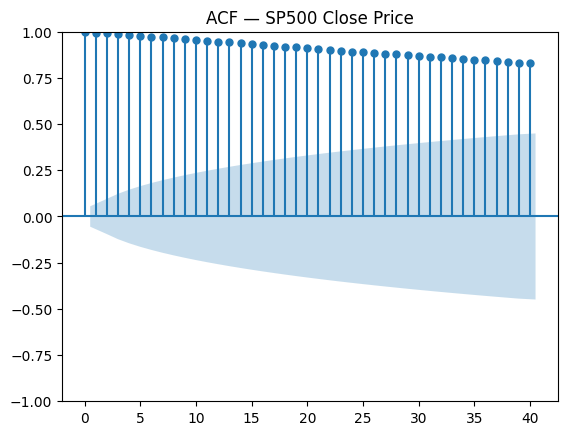

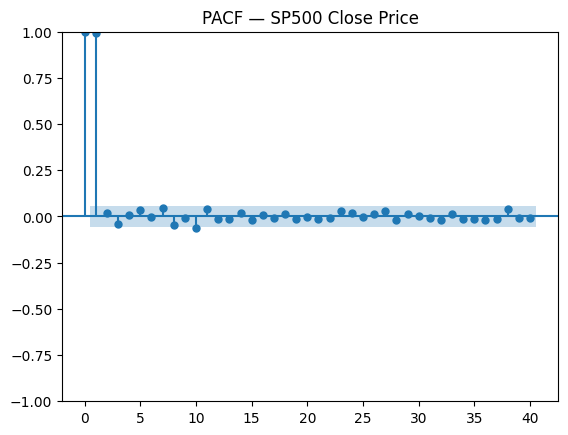

In [7]:
#@title 💰 Prepare SP500 dataset

sp500 = yf.download("^GSPC", start="2020-01-01", end="2024-12-31")

fig = plot_acf(y, lags=40, title='ACF — SP500 Close Price')
plt.show()
fig = plot_pacf(y, lags=40,title='PACF — SP500 Close Price')
plt.show()

# 🤖 Models

In [8]:
#@title 🧮 Build and fit Linear Regression

#@markdown * **Always use sm.add_constant(X)** unless you want to force intercept = 0
#@markdown * **OLS(y, X) takes y first**, X second (opposite of sklearn!)


X = mtcars_data['wt']
y = mtcars_data['mpg']

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

mtcars_data['fitted_values'] = results.fittedvalues
mtcars_data['line_color'] = 'red'

results_dict = {'r2': round(float(results.rsquared),2),
                'adj_r2': round(float(results.rsquared_adj),2),
                'aic': round(float(results.aic),2),
                'bic': round(float(results.bic),2)}

fig_scatter = px.scatter(mtcars_data, x='wt', y='mpg')
fig_line = px.line(mtcars_data, x='wt', y='fitted_values')
fig_line.update_traces(line=dict(color='red', width=2))
fig = go.Figure(data=fig_scatter.data + fig_line.data)
fig.update_layout(
    title=f'OLS fit of Linear Regression with results: {results_dict}',
    xaxis_title='Weight (1000 lbs)',
    yaxis_title='MPG'
)

fig.show()



                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     91.38
Date:                Fri, 20 Feb 2026   Prob (F-statistic):           1.29e-10
Time:                        13:37:42   Log-Likelihood:                -80.015
No. Observations:                  32   AIC:                             164.0
Df Residuals:                      30   BIC:                             167.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.2851      1.878     19.858      0.0

In [9]:
#@title 🌡️ Run 4-step diagnostics for OLS
#@markdown **Jarque-Bera**: Tests whether your residuals are normally distributed by checking **<i>skewness and kurtosis</i>**. OLS assumes normality for valid inference (t-stats, p-values).
#@markdown <br>**Breusch-Pagan**: Tests whether residual variance is constant across all observations (**<i>homoskedasticity</i>**). If violated, your standard errors are wrong → use HC3.
#@markdown <br>**Durbin-Watson**: Tests whether residuals are **correlated** with each other sequentially. Common in time series — if residuals are autocorrelated, OLS efficiency and inference break down.
#@markdown <br>**Cook's Distance**: Measures how much your coefficient estimates would change if you **<i>removed a specific observation</i>**. High value = that point is pulling your regression line disproportionately.

def run_diagnostics(model, results):
    jb_stat, jb_p, _, _ = jarque_bera(results.resid)
    bp_stat, bp_p, _, _ = het_breuschpagan(results.resid, model.exog)
    dw = durbin_watson(results.resid)

    influence = results.get_influence()
    cooks_d = influence.cooks_distance[0]
    threshold = 4 / len(results.resid)
    n_influential = (cooks_d > threshold).sum()

    print(f"Jarque-Bera p-value:   {jb_p:.3f} {'✅' if jb_p > 0.05 else '❌ non-normal'}")
    print(f"Breusch-Pagan p-value: {bp_p:.3f} {'✅' if bp_p > 0.05 else '❌ heteroskedastic'}")
    print(f"Durbin-Watson:         {dw:.3f} {'✅' if 1.5 < dw < 2.5 else '❌ autocorrelation'}")
    print(f"Cook's Distance:       {n_influential} influential points {'✅' if n_influential == 0 else '⚠️ investigate!'}")

run_diagnostics(model, results)

Jarque-Bera p-value:   0.301 ✅
Breusch-Pagan p-value: 0.841 ✅
Durbin-Watson:         1.252 ❌ autocorrelation
Cook's Distance:       3 influential points ⚠️ investigate!


In [10]:
#@title 🧺 Compare models based on X choice and Akaike criterion

preselected_cols = ['drat', 'hp', 'carb_4', 'carb_1'] #@param

X = pd.concat([mtcars_data[['cyl', 'disp', 'hp', 'drat', 'wt', 'qsec']], pd.get_dummies(mtcars_data[['vs', 'am', 'gear', 'carb']].astype(str), dtype='int')], axis=1)
y=mtcars_data['mpg']

models = {col: sm.OLS(y, X[[col] + preselected_cols]).fit() for col in X.columns}
# # Compare multiple models — lower is better

summary_dict = {name: round(float(m.aic),2) for name, m in models.items()}
summary_df = pd.DataFrame([summary_dict]).T.reset_index()
summary_df.columns = ['column', 'aic']

px.bar(summary_df.sort_values(by='aic'), x='column', y ='aic',
       title=f'Summary with preselected cols {preselected_cols}. Lowest aic: {summary_df.aic.min()}')

In [11]:
#@title 🤠 Ridge and Lasso regression

X=pd.concat([mtcars_data[['cyl', 'disp', 'hp', 'drat', 'wt', 'qsec']],
               pd.get_dummies(mtcars_data[['vs', 'am', 'gear', 'carb']].astype(str), dtype='int')], axis=1)
y=mtcars_data['mpg']

# L1_wt=0.0 means pure Ridge
ridge = sm.OLS(y, X).fit_regularized(alpha=10.0, L1_wt=0.0)
ridge_df = pd.DataFrame(ridge.params)
ridge_df['column'] = X.columns
ridge_df.columns=['coef', 'column']

fig = px.bar(ridge_df, x='column', y='coef', title='Ridge regression')
fig.show()

# L1_wt=1.0 means pure Lasso
lasso = sm.OLS(y, X).fit_regularized(alpha=28.0, L1_wt=1.0)

fig = px.bar(lasso.params, title='Lasso regression')
fig.show()

# L1_wt=0.5 means 50% Ridge + 50% Lasso
elastic = sm.OLS(y, X).fit_regularized(alpha=0.1, L1_wt=0.5)

fig = px.bar(elastic.params, title='ElasticNet regression')
fig.show()

# Ridge with cross-validated alpha
ridge_cv = RidgeCV(alphas=np.linspace(0.01, 1, 50), cv=5)
ridge_cv.fit(X, y)
print(f"Best alpha for Ridge: {ridge_cv.alpha_}")

# Lasso with cross-validated alpha
lasso_cv = LassoCV(alphas=np.linspace(0.01, 1, 50), cv=5)
lasso_cv.fit(X, y)
print(f"Best alpha for Lasso: {lasso_cv.alpha_}")

Best alpha for Ridge: 1.0
Best alpha for Lasso: 0.1716326530612245


In [12]:
#@title 🥱 Plot residuals and check with normal distribution

residuals = results.resid
fig = px.histogram(pd.Series(residuals, name='Residuals'), histnorm='probability density')

x_range = np.linspace(-10, 10, 100)
y_normal = stats.norm.pdf(x_range, 0, 1)

fitted_normal = stats.norm.pdf(x_range, residuals.mean(), residuals.std())

fig.add_trace(go.Scatter(
    x=x_range,
    y=fitted_normal,
    mode='lines',
    name='Fitted Normal',
    line=dict(color='green', width=2)
))

# fig.add_trace(go.Scatter(x=x_range, y=y_normal, mode='lines',
#                          name='N(0,1)', line=dict(color='red', width=2)))
fig.show()

In [13]:
#@title 👀 QQ plot of the residuals

def qq_plot(residuals: pd.Series):
    # Get theoretical quantiles and ordered residuals
    (theoretical_quantiles, ordered_residuals), (slope, intercept, r) = stats.probplot(residuals)

    # Reference line points
    x_line = np.array([theoretical_quantiles.min(), theoretical_quantiles.max()])
    y_line = slope * x_line + intercept

    fig = go.Figure()

    # Scatter points
    fig.add_trace(go.Scatter(
        x=theoretical_quantiles,
        y=ordered_residuals,
        mode='markers',
        name='Residuals',
        marker=dict(color='steelblue', size=6)
    ))

    # Reference line
    fig.add_trace(go.Scatter(
        x=x_line,
        y=y_line,
        mode='lines',
        name='Reference Line',
        line=dict(color='red', dash='dash')
    ))

    fig.update_layout(
        title='QQ Plot of Residuals',
        xaxis_title='Theoretical Quantiles',
        yaxis_title='Sample Quantiles',
        template='plotly_white'
    )

    fig.show()

residuals = results.resid
qq_plot(residuals)

In [14]:
#@title 💪 Build and fit a Robust Linear Model

X = pd.concat([mtcars_data[['cyl', 'disp', 'hp', 'drat', 'wt', 'qsec']],
               pd.get_dummies(mtcars_data[['vs', 'am', 'gear', 'carb']].astype(str), dtype='int')], axis=1)
y=mtcars_data['mpg']

rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
results = rlm_model.fit()
print(results.summary())


                    Robust linear Model Regression Results                    
Dep. Variable:                    mpg   No. Observations:                   32
Model:                            RLM   Df Residuals:                       16
Method:                          IRLS   Df Model:                           15
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 20 Feb 2026                                         
Time:                        13:37:47                                         
No. Iterations:                    50                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cyl           -1.6699      1.014     -1.647      0.1

In [15]:
#@title 👪 Fit a Poisson Generalized Linear Model


X = pd.get_dummies(ships_data[['type', 'year', 'period']], drop_first=True, dtype=int)
X = sm.add_constant(X)
offset = np.log(ships_data['service'])
y = ships_data['incidents']

model = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset).fit()
print(model.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:              incidents   No. Observations:                   26
Model:                            GLM   Df Residuals:                       19
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -74.728
Date:                Fri, 20 Feb 2026   Deviance:                       51.589
Time:                        13:37:47   Pearson chi2:                     58.3
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9643
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.7517      0.894    -10.912      0.0

In [18]:
#@title 🩻 Fit a Gamma Generalized Linear Model

X = insurance_data[[col for col in insurance_data.columns if col != 'Claims']]
insurance_y = insurance_data['Claims']
X['District'] = X['District'].astype(str)
X_dummy = pd.get_dummies(insurance_data[['District', 'Group', 'Age']], dtype=int)
insurance_X = pd.concat([X_dummy, X['Holders']], axis=1)

model = sm.GLM(insurance_y, insurance_X, family=sm.families.Gamma()).fit()
print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Claims   No. Observations:                   63
Model:                            GLM   Df Residuals:                       54
Model Family:                   Gamma   Df Model:                            8
Link Function:           InversePower   Scale:                         0.47880
Method:                          IRLS   Log-Likelihood:                -328.88
Date:                Fri, 20 Feb 2026   Deviance:                       82.759
Time:                        13:39:30   Pearson chi2:                     25.9
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1373
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
District         0.0203      0.003      7.179   

/tmp/ipython-input-2384741679.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning:

The InversePower link function does not respect the domain of the Gamma family.



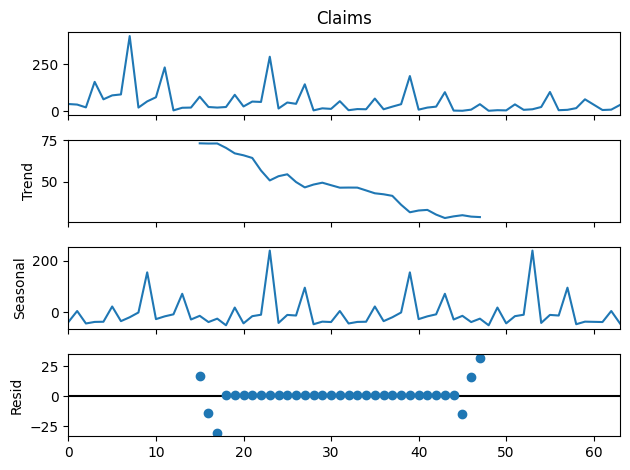

In [22]:
#@title ☀️ Seasonal decomposition

decomposition = seasonal_decompose(insurance_y, model='additive', period=30)
decomposition.plot()
plt.show()

In [40]:
#@title 💡 Fit Auto Arima

#@markdown **ARIMA(2,0,0)** = pure AR(2) process so I should see for **PACF - sharp cutoff after lag 2** (only lags 1 and 2 are significant) and for ACF (gradual, oscillating decay (tails off slowly).
# Fit auto_arima
model = pm.auto_arima(y,
                      start_p=0, max_p=5,   # AR range to search
                      start_q=0, max_q=5,   # MA range to search
                      d=None,
                      m=5,
                      seasonal=True,       # set True for SARIMA
                      information_criterion='aic',  # model selection metric
                      stepwise=False,        # faster search
                      trace=True)           # print search progress

print(model.summary())

 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=13329.477, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=13330.463, Time=0.75 sec
 ARIMA(0,1,0)(0,0,2)[5] intercept   : AIC=13327.096, Time=1.36 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=13330.601, Time=0.26 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=13331.626, Time=2.74 sec
 ARIMA(0,1,0)(1,0,2)[5] intercept   : AIC=13320.989, Time=3.15 sec
 ARIMA(0,1,0)(2,0,0)[5] intercept   : AIC=13326.406, Time=3.65 sec
 ARIMA(0,1,0)(2,0,1)[5] intercept   : AIC=13320.825, Time=2.57 sec
 ARIMA(0,1,0)(2,0,2)[5] intercept   : AIC=13322.823, Time=3.00 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=13322.690, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=13324.272, Time=0.79 sec
 ARIMA(0,1,1)(0,0,2)[5] intercept   : AIC=13322.328, Time=1.44 sec
 ARIMA(0,1,1)(1,0,0)[5] intercept   : AIC=13324.320, Time=0.63 sec
 ARIMA(0,1,1)(1,0,1)[5] intercept   : AIC=13325.818, Time=2.09 sec
 ARIMA(0,1,1)(1,0,2)[5] intercept   : AIC=13316.775, Time=3.52

In [36]:
#@title ⏱️ Periodogram for seasonality

y_diff = np.log(y).diff().dropna()
freqs, power = periodogram(y_diff.values)
dominant_freq = freqs[power.argmax()]
dominant_period = 1 / dominant_freq

print(f"Dominant_freq: {dominant_freq}")
print(f"Dominant period: {dominant_period:.1f} lags")

Dominant_freq: 0.4251592356687898
Dominant period: 2.4 lags


In [38]:
 #@title 🏭 STL decomposition
 #@markdown **STL - **Seasonal and Trend decomposition using Loess** (**Locally Estimated Scatterplot Smoothing**) - fits a low-degree polynomial at each point using only nearby observations weighted by distance.
 #@markdown <br><br> **STL uses LOESS twice** - once for seasonality and once for trend.
 #@markdown <br><br> **Seasonal pattern is allowed to change slowly** over time rather than being fixed.

resid_var_dict = {}
for m in range(2,100):
    stl = STL(y, period=m).fit()
    resid_var = stl.resid.var()
    resid_var_dict[m] = resid_var

stl_summary = pd.DataFrame([resid_var_dict]).T.reset_index()
stl_summary.columns=['m', 'resid_var']

px.bar(stl_summary, x='m', y='resid_var', title='Residual variance based on seasonality param m')

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.869e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9275.03
Distribution:                  Normal   AIC:                           18558.1
Method:            Maximum Likelihood   BIC:                           18578.6
                                        No. Observations:                 1257
Date:                Fri, Feb 20 2026   Df Residuals:                     1256
Time:                        13:54:39   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu          4163.5837     30.517    136.435      0.000 [4.

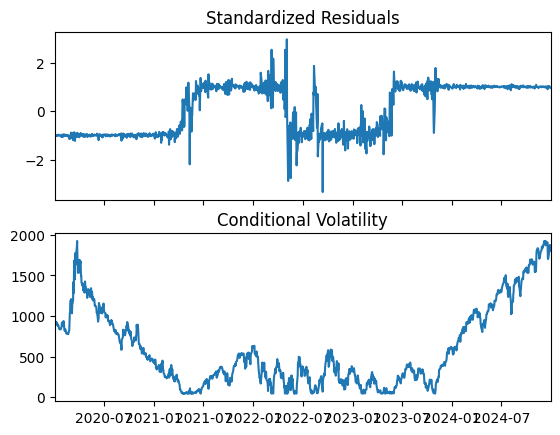

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
Date,,,,,,,,,,
2024-12-30,3.032679e+06,3.026085e+06,3.019510e+06,3.012953e+06,3.006415e+06,2.999896e+06,2.993395e+06,2.986912e+06,2.980448e+06,2.974001e+06


In [39]:
#@title 👁️ Fit GARCH

# Fit GARCH(1,1) — most common specification
model = arch_model(y, vol='Garch', p=1, q=1, dist='normal')
results = model.fit(disp='off')
print(results.summary())

# Plot conditional volatility
results.plot()
plt.show()

# Forecast volatility
vol_forecast = results.forecast(horizon=10)
display(vol_forecast.variance)

In [41]:
#@title 👨‍🔬Statistical tests

# Download data
y = sp500['Close'].squeeze().dropna()
returns = np.log(y).diff().dropna()

# Fit basic OLS for tests that need a model
X = sm.add_constant(np.arange(len(returns)))
model = sm.OLS(returns.values, X).fit()

# ---1. T-test — are SP500 returns different from zero?---
t_stat, p_value = ttest_1samp(returns, 0)
print(f"T-test: stat={t_stat:.3f}, p={p_value:.3f}")
print(f"→ Returns {'are' if p_value < 0.05 else 'are NOT'} significantly different from zero\n")

# ---2. ANOVA — compare returns across years---
groups = [returns[returns.index.year == yr] for yr in range(2020, 2025)]
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA: stat={f_stat:.3f}, p={p_value:.3f}")
print(f"→ Returns {'differ' if p_value < 0.05 else 'do NOT differ'} significantly across years\n")

# ---3. White's Test---
white_stat, white_p, _, _ = het_white(model.resid, model.model.exog)
print(f"White's Test: stat={white_stat:.3f}, p={white_p:.3f}")
print(f"→ {'Heteroskedasticity detected' if white_p < 0.05 else 'No heteroskedasticity'}\n")

# ---4. Granger Causality — does lagged SP500 return predict next return?---
# Clean approach — just pass 2 columns, grangercausalitytests handles lags internally
granger_df = pd.DataFrame({
    'returns': returns.values[1:],
    'lagged_returns': returns.values[:-1]
})

print("Granger Causality Test:")
grangercausalitytests(granger_df, maxlag=3, verbose=True)

# ---5. ADF — is SP500 return series stationary?---
adf_stat, adf_p, _, _, critical_values, _ = adfuller(returns)
print(f"\nADF Test: stat={adf_stat:.3f}, p={adf_p:.3f}")
print(f"→ Series {'is' if adf_p < 0.05 else 'is NOT'} stationary")

T-test: stat=1.243, p=0.214
→ Returns are NOT significantly different from zero

ANOVA: stat=0.795, p=0.528
→ Returns do NOT differ significantly across years

White's Test: stat=60.950, p=0.000
→ Heteroskedasticity detected

Granger Causality Test:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.0996 , p=0.0003  , df_denom=1251, df_num=1
ssr based chi2 test:   chi2=13.1310 , p=0.0003  , df=1
likelihood ratio test: chi2=13.0627 , p=0.0003  , df=1
parameter F test:         F=13.0996 , p=0.0003  , df_denom=1251, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0426  , p=0.9583  , df_denom=1249, df_num=2
ssr based chi2 test:   chi2=0.0854  , p=0.9582  , df=2
likelihood ratio test: chi2=0.0854  , p=0.9582  , df=2
parameter F test:         F=6.5727  , p=0.0014  , df_denom=1249, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9718  , p=0.0308  , df_denom=1247, df_num=3
ssr based chi2 test:  

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results

